In [1]:
import sqlite3
import time
from IPython import display
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
db = sqlite3.connect('spectra.sqlite3')

In [3]:
def load_run(run_id):
    data = db.execute('SELECT step, voltage, voltage_stdev FROM measurements WHERE run_id = ? AND led_on = 1 ORDER BY step ASC', (run_id,)).fetchall()
    return zip(*data)

In [24]:
def load_run_zero_cal(run_id, max_stdev=1e10):
    data = db.execute('SELECT a.step, a.voltage, a.voltage_stdev, b.voltage, b.voltage_stdev '
           'FROM measurements a JOIN measurements b USING (step) '
           'WHERE a.run_id = ?1 AND a.led_on = 1 AND b.run_id = ?1 AND b.led_on = 0 '
            'AND a.voltage_stdev < ?2 AND b.voltage_stdev < ?2'
           'ORDER BY step ASC', (run_id, max_stdev)).fetchall()
    steps, voltages, voltage_stdevs, zero_voltages, zero_stdevs = map(np.array, zip(*data))
    return steps, voltages-zero_voltages, np.sqrt(np.square(voltage_stdevs) + np.square(zero_stdevs))

In [12]:
def plot_rgb(id_r, id_g, id_b, loader=load_run):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle('Runs {}, {}, {} at {:%y-%m-%d %H:%M:%S}'.format(id_r, id_g, id_b, datetime.now()))
    for run_id, color in [(id_g, 'green'), (id_r, 'red'), (id_b, 'blue')]:
        steps, values, stdev = loader(run_id)
        ax.errorbar(steps, values, yerr=stdev, color=color)
        #ax.set_ylim([2.2, 5])
    #plt.close(fig)
    #return fig

<IPython.core.display.Javascript object>


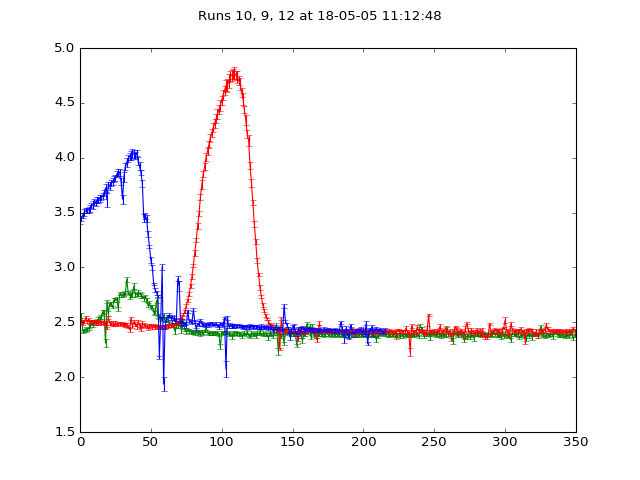

In [15]:
plot_rgb(10, 9, 12)

In [16]:
def live_plot_rgb(id_r, id_g, id_b, interval=1, loader=load_run):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle('Runs {}, {}, {} at {:%y-%m-%d %H:%M:%S}'.format(id_r, id_g, id_b, datetime.now()))
    
    while True:
        ax.clear()
        for run_id, color in [(id_g, 'green'), (id_r, 'red'), (id_b, 'blue')]:
            steps, values, stdev = loader(run_id)
            ax.errorbar(steps, values, yerr=stdev, color=color)
        fig.canvas.draw()
        time.sleep(1)

<IPython.core.display.Javascript object>


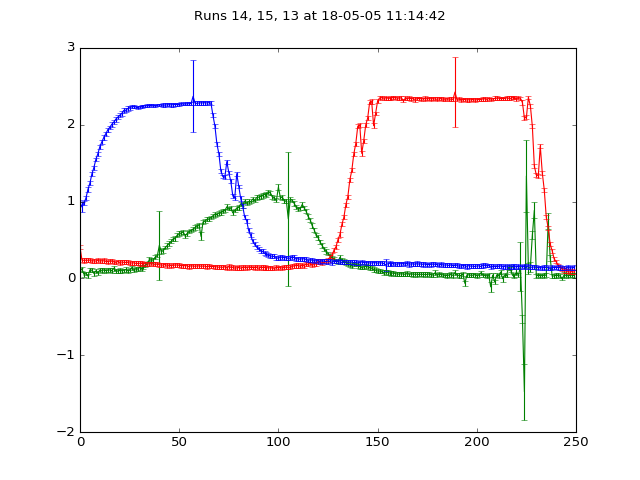

KeyboardInterrupt: 

In [18]:
#live_plot_rgb(14, 15, 13, loader=load_run_zero_cal)

In [39]:
import scipy.interpolate as inter

def live_plot_rgb_splines(id_r, id_g, id_b, max_stdev=0.05, spline_s=1, interval=1, live=True):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle('Runs {}, {}, {} at {:%y-%m-%d %H:%M:%S}'.format(id_r, id_g, id_b, datetime.now()))
    
    while True:
        ax.clear()
        colors = [
            ((1,0,0), (1,0.5,0.5)),
            ((0,1,0), (0.5,1,0.5)),
            ((0,0,1), (0.5,0.5,1))
        ]
        for run_id, (color_dark, color_bright) in zip([id_r, id_g, id_b], colors):
            steps, values, stdev = load_run_zero_cal(run_id, max_stdev)
            spline = inter.UnivariateSpline(steps, values, s=spline_s)
            ax.errorbar(steps, values, yerr=stdev, color=color_bright)
            ax.plot(steps, spline(steps), color=color_dark)
        fig.canvas.draw()
        if not live:
            break
        time.sleep(1)

<IPython.core.display.Javascript object>


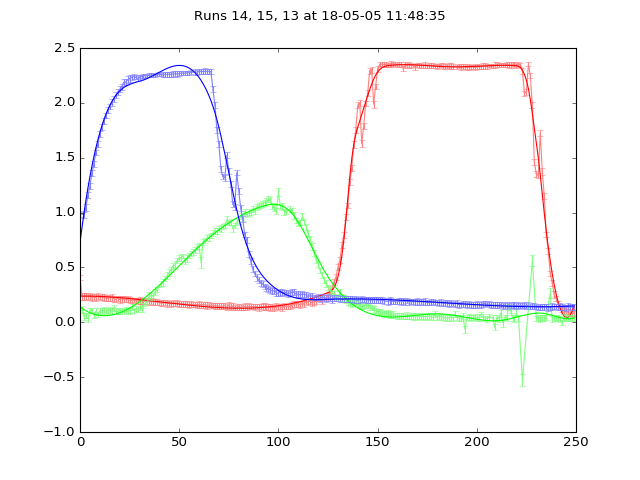

In [40]:
live_plot_rgb_splines(14, 15, 13, live=False)

* Go further than step 250 to capture some zeros beyond the red band to allow the spline fitter to do its job more properly
* Move the entire screen further down and further increase range to properly capture blue rolloff
* Decrease amplification to avoid clipping. Maybe change amplification midway for green channel. Currenlty set to 5GOhm using 10M transimp feedback R with 1:10 T feedback and ~1:50 gain voltage amp stage. Maybe go back to plain transimp amp with 10M gain, for a total gain of 500M
* Decrease VGND bias to allow for more headroom